In [75]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

# Principais Estruturas

In [76]:
class Atribute:
    name: str
    mode = None
    values: list
    next: dict = dict()

    def __init__(self, name, mode=None, values=None):
        self.name = name
        self.values = values
        self.mode = mode

    def add_next(self, value: str, next_atribute):
        self.next[value] = next_atribute

    def get_next(self, value: str):
        if value not in self.next.keys():
            return None
        return self.next[value]

    def set_mode(self, mode: str):
        self.mode = mode

    def get_name(self):
        return self.name

    def get_mode(self):
        return self.mode

    def get_values(self):
        return self.values

class DecisionTree:
    labels: list
    n_labels: int
    root: Atribute
    features: list
    predictions: list
    confusion_matrix: np.array

    def __init__(self):
        self.features = []
        self.labels = []
        self.root = None

    def information_gain(self, s: pd.DataFrame, atribute: str):
        values = s[atribute].unique()
        sum = 0
        for value in values:
            sv = s[s[atribute]==value]
            pv = len(sv) / len(s)
            ev = self.entropy(sv)
            sum = sum + pv*ev
        return self.entropy(s) - sum

    def entropy(self, s: pd.DataFrame):
        if len(s) == 0:
            return 0

        labels = s.target.unique()
        n_labels = s.target.nunique()
        proba = []

        for label in labels:
            proba.append(len(s[s.target == label]) / len(s))

        if 0 in proba or len(proba)==1:
            return 0
        else:
            entropy = 0
            for p in proba:
                entropy -= p*math.log(p, n_labels)

        return entropy

    def train_model(self, samples: pd.DataFrame, prev: Atribute, value: str):
        if samples.target.empty:
            if prev == None:
                return

            node = Atribute(name=prev.get_mode())
            node.add_next('class', None)

            prev.add_next(value, node)
            return

        if len(self.features) == 0 or samples.target.nunique() == 1:
            classification = samples.target.mode().loc[0]
            node = Atribute(name=classification)
            node.add_next('class', None)

            prev.add_next(value, node)

            return

        most_relevant = ['', -1]
        for atribute in self.features:
            name = atribute.get_name()
            gain = self.information_gain(samples, name)
            if gain > most_relevant[1]:
                most_relevant = [atribute, gain]

        atribute, _ = most_relevant
        atribute_mode = samples.target.mode().loc[0]

        node = Atribute(atribute.get_name(), mode=atribute_mode, values=atribute.get_values())

        self.features.remove(atribute)

        if prev != None:
            prev.add_next(value, node)
        else:
            self.root = node

        for value in node.get_values():
            subset = samples[samples[node.get_name()] == value]
            self.train_model(subset, node, value)

    def fit(self, train_samples: pd.DataFrame):
        self.labels = list(train_samples.target.unique())
        self.n_labels = len(self.labels)
        self.confusion_matrix = np.zeros((self.n_labels, self.n_labels))

        for feature in train_samples.drop(columns='target').columns.tolist():
            values = train_samples[feature].unique()
            self.features.append(Atribute(feature, None, values))

        self.train_model(train_samples, None, None)

    def predict(self, samples: pd.DataFrame):
        self.predictions = []

        test_mode = samples.target.mode().loc[0]
        current_node = self.root
        predicted_label = ''

        for _, row in samples.iterrows():
            current_node = self.root
            while current_node != None:
                node_name = current_node.get_name()
                if node_name in self.labels:
                    predicted_label = node_name
                    break

                value = row[node_name]
                next_node = current_node.get_next(value)

                if next_node == None:
                    predicted_label = test_mode
                    break

                current_node = next_node

            self.update_matrix(str(predicted_label), str(row.target))
            self.predictions.append(str(predicted_label))

    def prediction_values(self):
        return self.predictions

    def update_matrix(self, predicted_label: str, true_label: str):
        predicted_index = self.labels.index(predicted_label)
        true_index = self.labels.index(true_label)

        self.confusion_matrix[true_index][predicted_index] += 1

    def plot_confusion_matrix(self):
        cm = ConfusionMatrixDisplay(self.confusion_matrix, display_labels=self.labels)

        cm.plot()
        plt.show()

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções Utilitárias

In [78]:
def format_df(df: pd.DataFrame):
    for column in df.select_dtypes(include='number'):
        df[column].fillna(df[column].mean(), inplace=True)

    for column in df.select_dtypes(include='object'):
        df[column].fillna(df[column].mode().loc[0], inplace=True)

    return df

def drop_unwanted(df: pd.DataFrame, unwanted_labels: list):
    df.drop_duplicates(inplace=True)
    df.drop(df[df['NCAP Rating'] == 'Not Rated'].index, inplace=True)
    df.drop(df[df['NCAP Rating'] == 'Not Tested'].index, inplace=True)
    df.drop(columns=unwanted_labels, inplace=True)

    return df

def sturges_method(n: int):
    return math.ceil(math.sqrt(n))
   # return math.ceil(1 + 3.32 * math.log10(n))

def convert_to_categorical(df: pd.DataFrame):
    len_df = df.shape[0]

    n_classes = sturges_method(len_df)
    multiplier = 1
    for column in df.select_dtypes(include='number'):
        max = df[column].max()
        min = df[column].min()
        amplitude = max - min

        multiplier = 1
        categorized_column = []

        interval = (amplitude / n_classes) + 0.01

        ini = min
        for value in df[column].values:
            if value >= (min + (interval*multiplier)):
                ini += interval
                multiplier += 1

            categorized_column.append(str(np.round(ini, 1)) + ' -- ' + str(np.round(interval + ini, 1)))

        df.drop(columns=column, inplace=True)
        df.insert(1, column, categorized_column)

    return df

# Tratamento dos Dados

In [79]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Cars_India_Dataset.csv')

df = drop_unwanted(df, ['Model'])

df.sort_values(by=df.columns.tolist(), inplace=True)
df = convert_to_categorical(df)

for column in df.columns:
    df[column] = [str(text).rstrip() for text in df[column]]
    df[column] = [str(text).lstrip() for text in df[column]]
    df[column] = [str(text).replace(' ', '').upper() for text in df[column]]
    df[column] = [str(text).replace('NAN', df[column].mode().loc[0].upper()) for text in df[column]]

df.rename(columns={'NCAP Rating': 'target'}, inplace=True)
df

,Maker,Variants,Fuel Efficiency,Boot Space,Fuel Tank Capacity,Turning Radius,No_of_Cylinders,Wheelbase,Height,Width,...,Type,Fuel,Engine Type,Transmission,Front Brake,Rear Brake,Drive,Emission Type,Tyre Size,target
39,CITROEN,1--2.6,10.4--11.7,226.3--262.5,32.3--36.7,4.8--4.9,3.1--3.2,2475.2--2528.4,1505.8--1536.5,1622.3--1665.7,...,SUV,DIESEL,DW10FC,8AT,DISC,DISC,2WD,BSVI,235/55R18,4
17,HONDA,1--2.6,11.7--13.1,262.5--298.8,36.7--41.0,4.9--5.0,3.2--3.3,2528.4--2581.5,1536.5--1567.3,1665.7--1709.0,...,COMPACTSUV,PETROL,SOHCI-VTEC,5MT,DISC,DRUM,2WD,BSVI,195/60R16,4
18,HONDA,1--2.6,13.1--14.4,298.8--335.0,36.7--41.0,5.0--5.1,3.3--3.4,2528.4--2581.5,1567.3--1598.0,1709.0--1752.4,...,COMPACTSUV,DIESEL,DOHCI-DTEC,6MT,DISC,DRUM,2WD,BSVI,195/60R16,4
8,HONDA,2.6--4.2,14.4--15.8,335.0--371.3,36.7--41.0,5.0--5.1,3.4--3.5,2528.4--2581.5,1567.3--1598.0,1709.0--1752.4,...,COMPACTSEDAN,PETROL,SOHCI-VTEC,5MT,DISC,DRUM,2WD,BSVI,175/65R15,4
9,HONDA,2.6--4.2,15.8--17.2,371.3--407.6,36.7--41.0,5.0--5.1,3.5--3.6,2528.4--2581.5,1567.3--1598.0,1709.0--1752.4,...,COMPACTSEDAN,PETROL,SOHCI-VTEC,CVT,DISC,DRUM,2WD,BSVI,175/65R15,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,VOLKSWAGEN,12.2--13.7,24.0--25.3,588.9--625.1,75.8--80.1,5.7--5.8,3.9--4.0,2900.6--2953.8,1813.4--1844.1,1969.1--2012.4,...,MIDSIZESUV,PETROL,1.0LTSI,6-SPEEDAT,DISC,DRUM,2WD,BSVI,205/55R17,5
3,VOLKSWAGEN,12.2--13.7,24.0--25.3,588.9--625.1,75.8--80.1,5.7--5.8,3.9--4.0,2900.6--2953.8,1813.4--1844.1,1969.1--2012.4,...,MIDSIZESUV,PETROL,1.0LTSI,6-SPEEDMT,DISC,DRUM,2WD,BSVI,205/55R17,5
5,VOLKSWAGEN,12.2--13.7,24.0--25.3,588.9--625.1,75.8--80.1,5.7--5.8,3.9--4.0,2900.6--2953.8,1813.4--1844.1,1969.1--2012.4,...,MIDSIZESUV,PETROL,1.5LTSIEVOWITHACT,6-SPEEDMT,DISC,DRUM,2WD,BSVI,205/55R17,5
6,VOLKSWAGEN,12.2--13.7,24.0--25.3,588.9--625.1,75.8--80.1,5.7--5.8,3.9--4.0,2900.6--2953.8,1813.4--1844.1,1969.1--2012.4,...,MIDSIZESUV,PETROL,1.5LTSIEVOWITHACT,7-SPEEDDSG,DISC,DRUM,2WD,BSVI,205/55R17,5


In [80]:
df.nunique()

Maker                 10
Variants               8
Fuel Efficiency       11
Boot Space            11
Fuel Tank Capacity    11
Turning Radius         9
No_of_Cylinders       10
Wheelbase              9
Height                11
Width                  9
Length                10
Displacement          11
Seats                  7
Type                   8
Fuel                   4
Engine Type           43
Transmission          19
Front Brake            1
Rear Brake             2
Drive                  3
Emission Type          1
Tyre Size             21
target                 6
dtype: int64

In [81]:
df.drop(columns=['Front Brake', 'Emission Type'], inplace=True)
x_train, x_test = train_test_split(df, test_size=0.2)
x_train = format_df(x_train)
x_test = format_df(x_test)

# Treinamento e Predição

In [82]:
dct = DecisionTree()

dct.fit(x_train)

In [83]:
dct.predict(x_test)

# Medidas de Desempenho

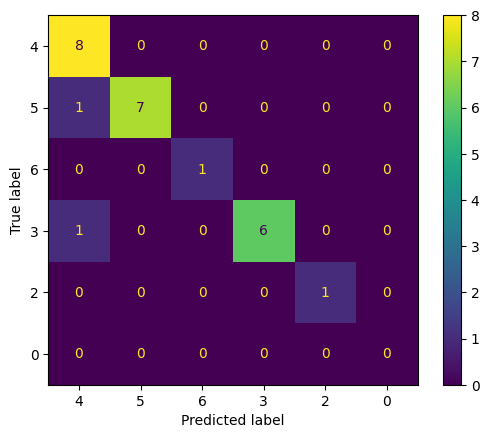

In [84]:
dct.plot_confusion_matrix()

In [85]:
y_pred = dct.prediction_values()
y_true = x_test.target.tolist()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           3       1.00      0.86      0.92         7
           4       0.80      1.00      0.89         8
           5       1.00      0.88      0.93         8
           6       1.00      1.00      1.00         1

    accuracy                           0.92        25
   macro avg       0.96      0.95      0.95        25
weighted avg       0.94      0.92      0.92        25

